In [345]:
# !pip install -qq scikit-uplift causalml

In [346]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds, plot_uplift_by_percentile, plot_uplift_curve
from sklift.models import SoloModel, ClassTransformation, TwoModels

from catboost import CatBoostClassifier

from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

seed = 42
np.random.seed(seed)

In [347]:
path = r'data.csv'
df = pd.read_csv(path)
df.sample(5) # make count feature = used_bogo + used_discount

recency  history  used_discount  used_bogo   zip_code  is_referral  \
33042        9    64.85              1          0  Surburban            1   
7209         1   144.12              0          1      Urban            0   
24367        1   734.25              0          1  Surburban            1   
19599        4  1321.26              1          0  Surburban            1   
31465        2   261.23              1          1  Surburban            1   

            channel            offer  conversion  
33042           Web         Discount           0  
7209            Web         Discount           0  
24367         Phone         Discount           0  
19599  Multichannel         Discount           1  
31465           Web  Buy One Get One           1

In [348]:
df['count'] = df['used_bogo'] + df['used_discount'] + df['is_referral']

In [349]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
 9   count          64000 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 4.9+ MB


In [350]:
df.describe()
# history > 1000 /= 10? 

recency       history  used_discount     used_bogo   is_referral  \
count  64000.000000  64000.000000   64000.000000  64000.000000  64000.000000   
mean       5.763734    242.085656       0.551031      0.549719      0.502250   
std        3.507592    256.158608       0.497393      0.497526      0.499999   
min        1.000000     29.990000       0.000000      0.000000      0.000000   
25%        2.000000     64.660000       0.000000      0.000000      0.000000   
50%        6.000000    158.110000       1.000000      1.000000      1.000000   
75%        9.000000    325.657500       1.000000      1.000000      1.000000   
max       12.000000   3345.930000       1.000000      1.000000      1.000000   

         conversion         count  
count  64000.000000  64000.000000  
mean       0.146781      1.603000  
std        0.353890      0.601345  
min        0.000000      1.000000  
25%        0.000000      1.000000  
50%        0.000000      2.000000  
75%        0.000000      2.000000  
max        1.000000      3.000000

In [351]:
df.describe(include=['object'])

zip_code channel            offer
count       64000   64000            64000
unique          3       3                3
top     Surburban     Web  Buy One Get One
freq        28776   28217            21387

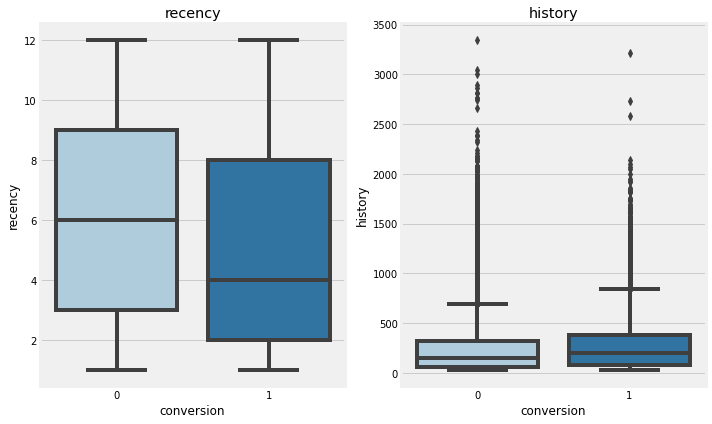

In [352]:
plt.figure(figsize=(10,6))
for i, column in enumerate(('recency', 'history'), 1):
    plt.subplot(1, 2, i)
    sns.boxplot(y=df[column], x=df['conversion'], data=df)
    plt.title(f'{column}')
plt.tight_layout()
plt.show()

In [353]:
df.loc[df['history'] >= 1000, 'history'] /= 10

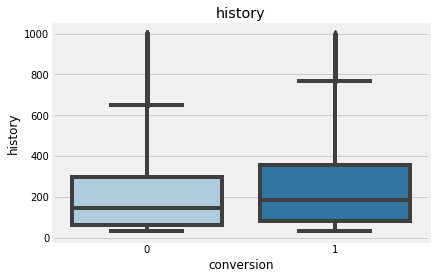

In [354]:
plt.title('history')
sns.boxplot(y=df['history'], x=df['conversion'], data=df)
plt.show()

#### Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [355]:
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})
df.head(1)

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   

         treatment  target  count  
0  Buy One Get One       0      1

In [356]:
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0
df.loc[df['treatment'] != 0, 'treatment'] = 1
df['treatment'] = df['treatment'].astype(np.uint8)
df['treatment'].describe()

count    64000.000000
mean         0.667094
std          0.471257
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: treatment, dtype: float64

In [357]:
df['history_cut'] = pd.cut(df['history'], bins=np.linspace(0, df['history'].max(), 4), labels=False)

In [358]:
X, y, treat = df.drop(['target', 'treatment'], axis=1), df['target'], df['treatment']

train_indices, test_indices = train_test_split(X.index, test_size=0.3, shuffle=True, stratify=treat, random_state=seed)

In [359]:
print(treat.value_counts(normalize=True))
print(treat[train_indices].value_counts(normalize=True))
print(treat[test_indices].value_counts(normalize=True))

1    0.667094
0    0.332906
Name: treatment, dtype: float64
1    0.667098
0    0.332902
Name: treatment, dtype: float64
1    0.667083
0    0.332917
Name: treatment, dtype: float64


In [360]:
X_train, y_train, treat_train = X.loc[train_indices, :], y[train_indices], treat[train_indices]
X_test, y_test, treat_test = X.loc[test_indices, :], y[test_indices], treat[test_indices]
print(f'Train size: {len(train_indices)}, test size: {len(test_indices)}')

Train size: 44800, test size: 19200


In [361]:
target_dict = pd.DataFrame(data=pd.concat([X_train, y_train], axis=1), 
                           index=X_train.index).groupby('recency')['target'].mean().to_dict()

X_train['target_enc'] = X_train['recency'].map(target_dict)
X_test['target_enc'] = X_test['recency'].map(target_dict)

```
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomUnderSampler(sampling_strategy=1., random_state=seed)
X_train_, treat_train_ = sampler.fit_resample(X_train, treat_train)
indices = sampler.sample_indices_
new_indices = [idx for idx in X_train.index if idx in indices]

X_train, y_train, treat_train = X_train.loc[new_indices, :], y_train[new_indices], treat_train[new_indices]
```

#### сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

добавили признаки, устранили выбросы, one-hot или target-encoding сделает catboost

#### провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [362]:
results = pd.DataFrame(columns=['S-learner', 'TargetTransform', 'Two-indep-models', 'TreeUplift', 'ForestUplift'], 
                       index=['uplift@10', 'uplift@20', 'uplift@30'])
cat_features = X.select_dtypes('object').columns.tolist()

#### S-learner

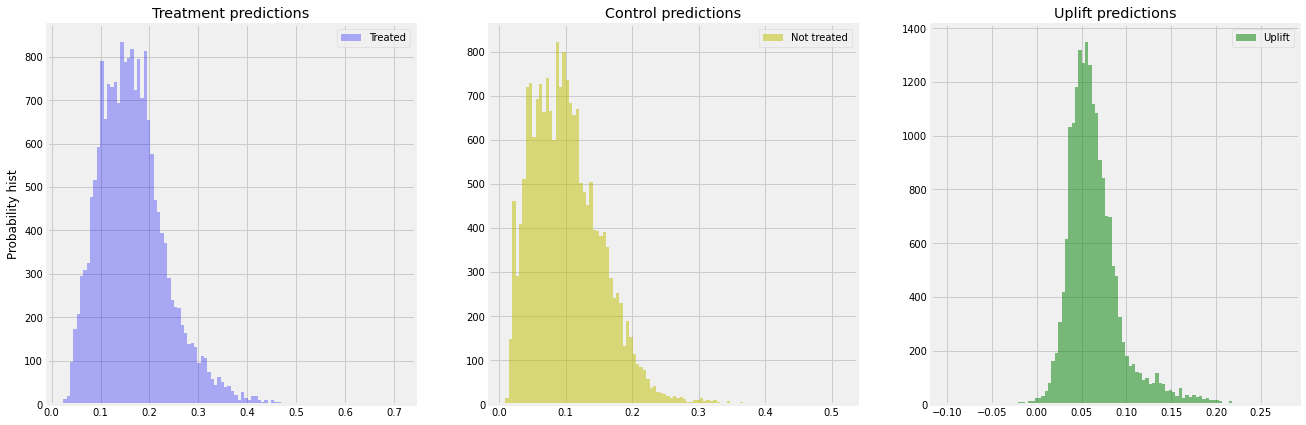

In [363]:
sm = SoloModel(CatBoostClassifier(iterations=100, thread_count=2, random_state=seed, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)

results['S-learner'] = [sm_score_10, sm_score_20, sm_score_30]

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

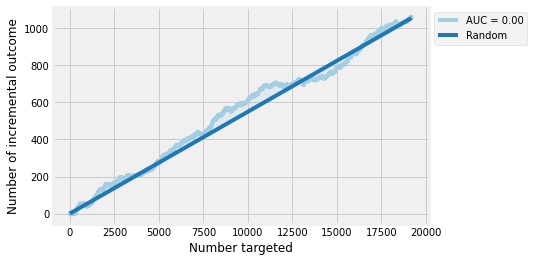

In [364]:
plot_uplift_curve(y_test, uplift_sm, treat_test, perfect=False)
plt.show()

#### ClassTransformation

In [365]:
ct = ClassTransformation(CatBoostClassifier(iterations=100, thread_count=2, random_state=seed, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

results['TargetTransform'] = [ct_score_10, ct_score_20, ct_score_30]

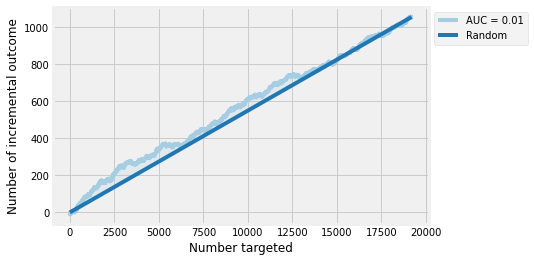

In [366]:
plot_uplift_curve(y_test, uplift_ct, treat_test, perfect=False)
plt.show()

#### two models

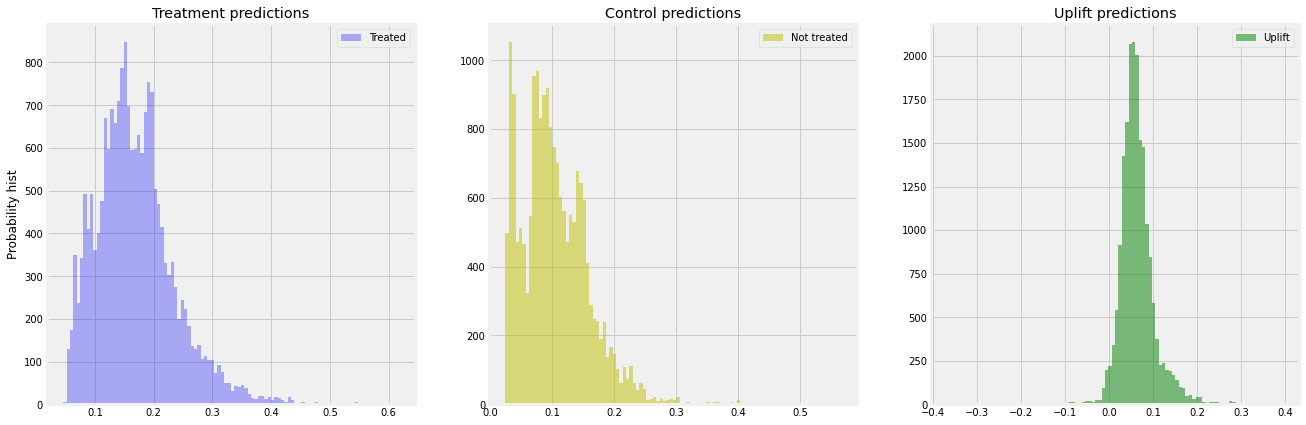

In [367]:
tm = TwoModels(estimator_trmnt=CatBoostClassifier(iterations=100, thread_count=2, random_state=seed, silent=True), 
               estimator_ctrl=CatBoostClassifier(iterations=100, thread_count=2, random_state=seed, silent=True), 
               method='vanilla' # Two independent models: error sums up
)
tm = tm.fit(
            X_train, y_train, treat_train,
            estimator_trmnt_fit_params={'cat_features': cat_features}, 
            estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

results['Two-indep-models'] = [tm_score_10, tm_score_20, tm_score_30]

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

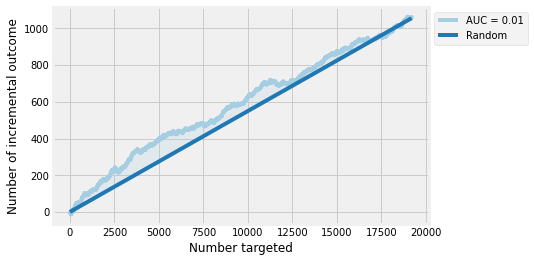

In [368]:
plot_uplift_curve(y_test, uplift_tm, treat_test, perfect=False)
plt.show()

#### two dependant models

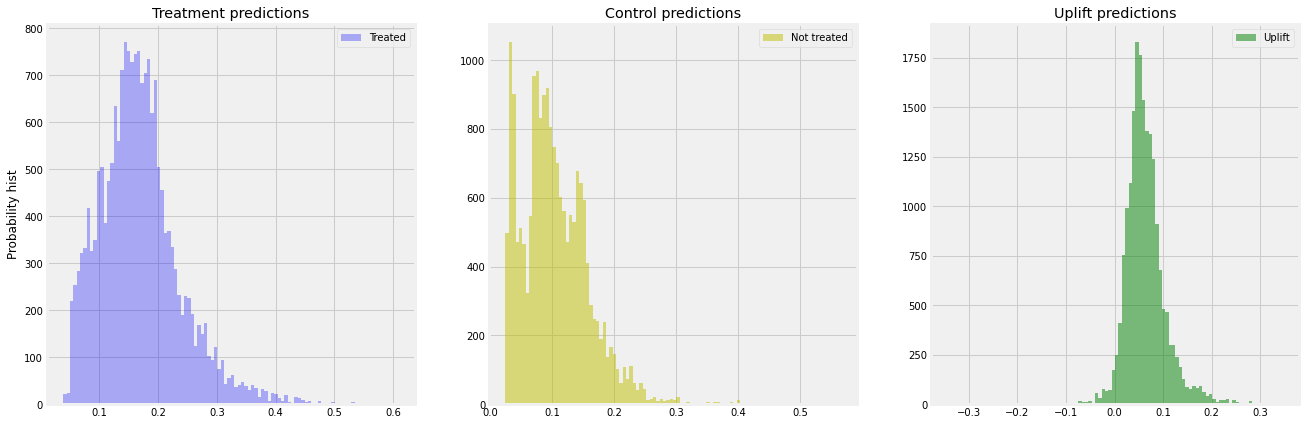

In [369]:
tm_d = TwoModels(estimator_trmnt=CatBoostClassifier(iterations=100, thread_count=2, random_state=seed, silent=True), 
                 estimator_ctrl=CatBoostClassifier(iterations=100, thread_count=2, random_state=seed, silent=True), 
                 method='ddr_control'
)
tm_d = tm_d.fit(
                X_train, y_train, treat_train,
                estimator_trmnt_fit_params={'cat_features': cat_features}, 
                estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_d = tm_d.predict(X_test)

tmd_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm_d, treatment=treat_test, strategy='by_group', k=0.1)
tmd_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm_d, treatment=treat_test, strategy='by_group', k=0.2)
tmd_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm_d, treatment=treat_test, strategy='by_group', k=0.3)

results['Two-dep-models'] = [tmd_score_10, tmd_score_20, tmd_score_30]

plot_uplift_preds(trmnt_preds=tm_d.trmnt_preds_, ctrl_preds=tm_d.ctrl_preds_);

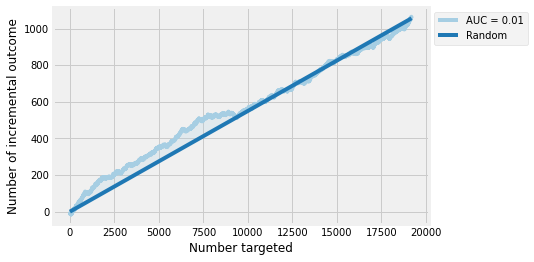

In [370]:
plot_uplift_curve(y_test, uplift_tm_d, treat_test, perfect=False)
plt.show()

#### Tree

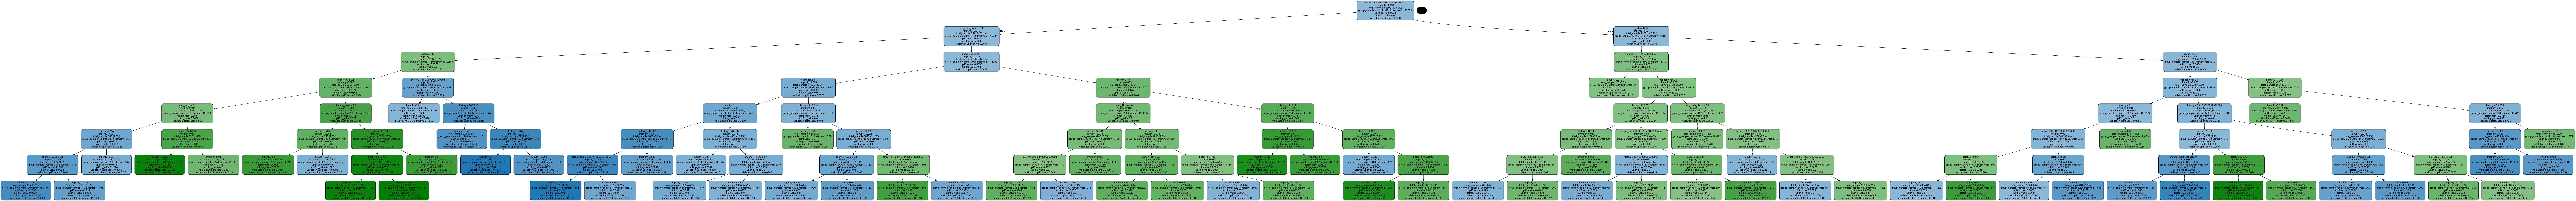

In [371]:
X_train_tree = pd.concat([X_train.drop(['channel', 'zip_code'], axis=1), 
                          pd.get_dummies(X_train['channel'], prefix='channel'),
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code')], axis=1)
features = [col for col in X_train_tree]

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

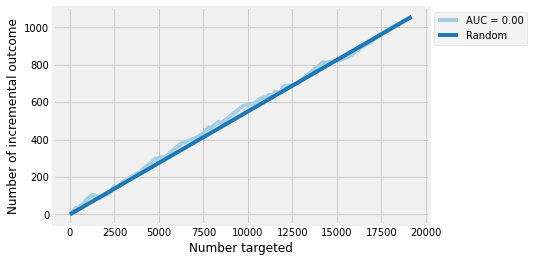

In [372]:
X_test_tree = pd.concat([X_test.drop(['channel', 'zip_code'], axis=1), 
                         pd.get_dummies(X_test['channel'], prefix='channel'),
                         pd.get_dummies(X_test['zip_code'], prefix='zip_code')], axis=1)

tree_test_lift = uplift_model.predict(X_test_tree)
tree_score_10 = uplift_at_k(y_true=y_test, uplift=tree_test_lift[:,1], treatment=treat_test, strategy='by_group', k=0.1)
tree_score_20 = uplift_at_k(y_true=y_test, uplift=tree_test_lift[:,1], treatment=treat_test, strategy='by_group', k=0.2)
tree_score_30 = uplift_at_k(y_true=y_test, uplift=tree_test_lift[:,1], treatment=treat_test, strategy='by_group', k=0.3)

results['TreeUplift'] = [tree_score_10, tree_score_20, tree_score_30]

plot_uplift_curve(y_test, tree_test_lift[:,1], treat_test, perfect=False)
plt.show()

#### Forest

In [373]:
X_train_tree_ = pd.concat([X_train.drop(['channel', 'zip_code'], axis=1), 
                           pd.get_dummies(X_train['channel'], prefix='channel'),
                           pd.get_dummies(X_train['zip_code'], prefix='zip_code')], axis=1)
features_ = [col for col in X_train_tree_]

uplift_model_ = UpliftRandomForestClassifier(n_estimators=20, 
                                             max_features=10, 
                                             max_depth=5, 
                                             min_samples_leaf=100, 
                                             min_samples_treatment=50,
                                             normalization=False,
                                             n_reg=100, 
                                             evaluationFunction='KL', 
                                             control_name='control', 
                                             random_state=seed,
                                             n_jobs=-1)

uplift_model_.fit(X_train_tree_.values,
                  treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                  y=y_train.values)

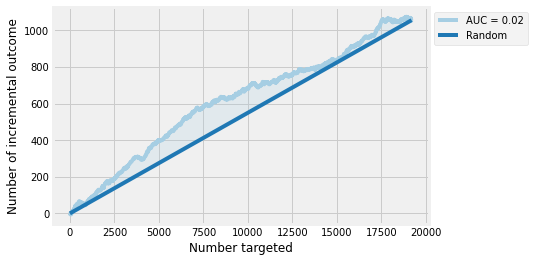

In [374]:
X_test_tree_ = pd.concat([X_test.drop(['channel', 'zip_code'], axis=1), 
                          pd.get_dummies(X_test['channel'], prefix='channel'),
                          pd.get_dummies(X_test['zip_code'], prefix='zip_code')], axis=1)

forest_test_lift = uplift_model_.predict(X_test_tree_.values).squeeze()
forest_score_10 = uplift_at_k(y_true=y_test.values, uplift=forest_test_lift, treatment=treat_test.values, strategy='by_group', k=0.1)
forest_score_20 = uplift_at_k(y_true=y_test.values, uplift=forest_test_lift, treatment=treat_test.values, strategy='by_group', k=0.2)
forest_score_30 = uplift_at_k(y_true=y_test.values, uplift=forest_test_lift, treatment=treat_test.values, strategy='by_group', k=0.3)

results['ForestUplift'] = [forest_score_10, forest_score_20, forest_score_30]

plot_uplift_curve(y_test, forest_test_lift, treat_test, perfect=False)
plt.show()

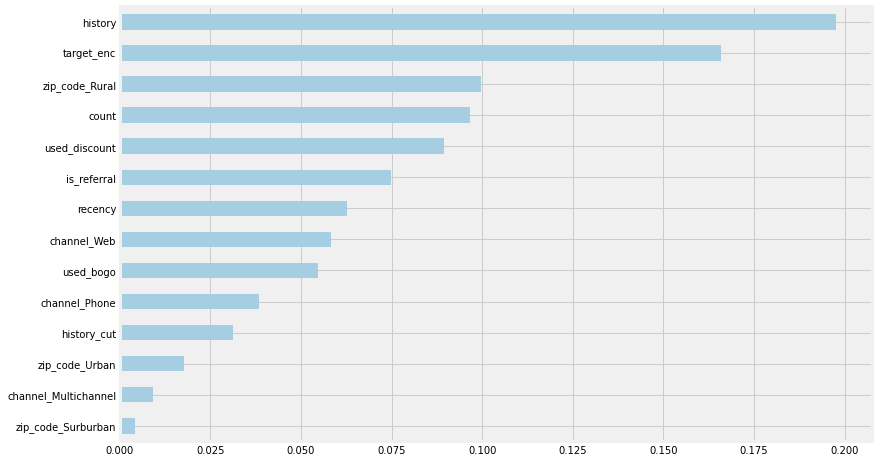

In [375]:
pd.Series(uplift_model_.feature_importances_, index=X_train_tree_.columns).sort_values().plot(kind='barh', figsize=(12,8))
plt.show()

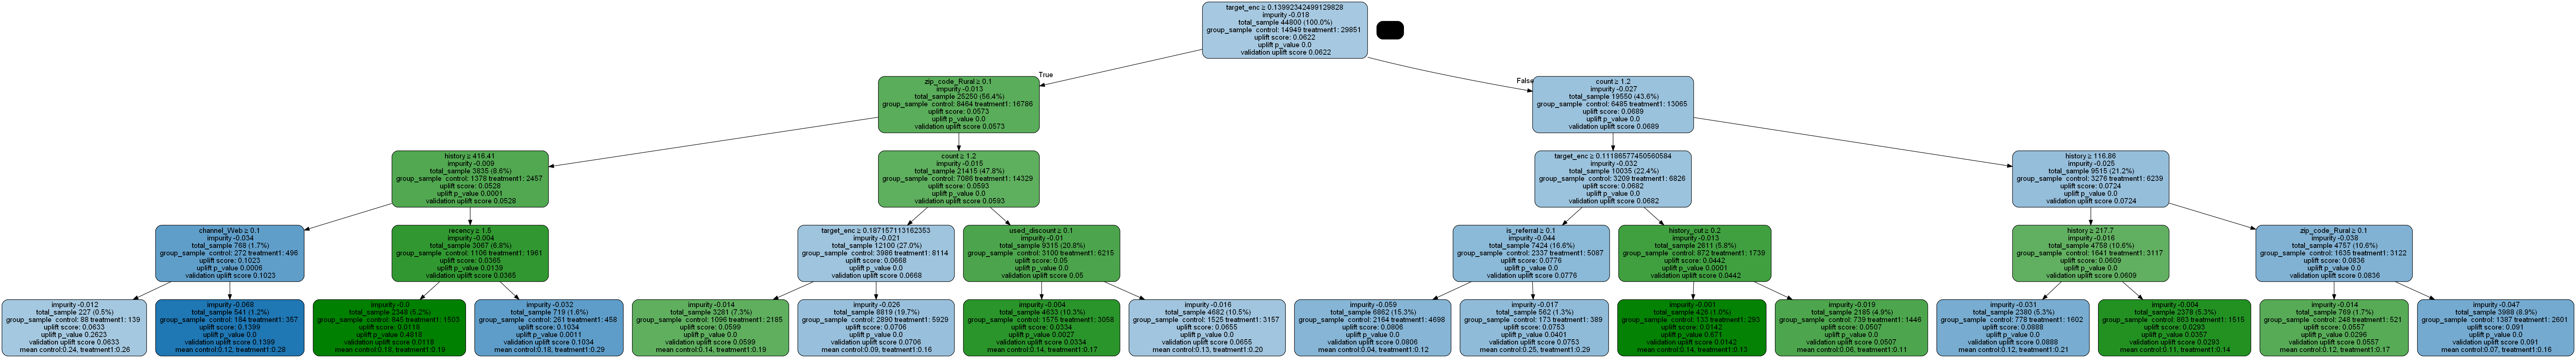

In [376]:
graph = uplift_tree_plot(uplift_model_.uplift_forest[0].fitted_uplift_tree, features)  # first tree in ensemble
Image(graph.create_png())

#### в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [377]:
results

S-learner  TargetTransform  Two-indep-models  TreeUplift  \
uplift@10   0.070036         0.084130          0.092736    0.045781   
uplift@20   0.055918         0.073890          0.087209    0.060582   
uplift@30   0.059563         0.065024          0.075216    0.059540   

           ForestUplift  Two-dep-models  
uplift@10      0.078681        0.096645  
uplift@20      0.081373        0.073533  
uplift@30      0.078378        0.067939

#### Лучший результат показала модель с двумя зависимыми моделями на первых 10%, при увеличении количества клиентов (20%) значение $uplift$ лучше у модели с двумя зависимыми моделями. Результат сильно зависит от предобработки данных.

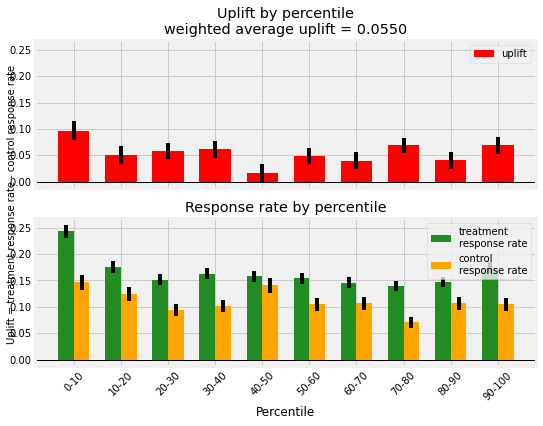

In [378]:
plot_uplift_by_percentile(y_test, uplift_tm_d, treat_test, strategy='by_group', kind='bar')
plt.show()

import os

os.environ['PATH'] = os.environ['PATH']+';'+r"C:\Program Files\Graphviz\bin"
os.environ['PATH'] = os.environ['PATH']+';'+r"C:\Program Files\Graphviz"

#### (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 
1. сделать прогноз и получить uplift для тестовой выборки 
2. отсортировать тестовую выборку по uplift по убыванию 
3. разбить на децили (pandas qcut вам в помощь) 
4. для каждого дециля посчитать среднюю conversion

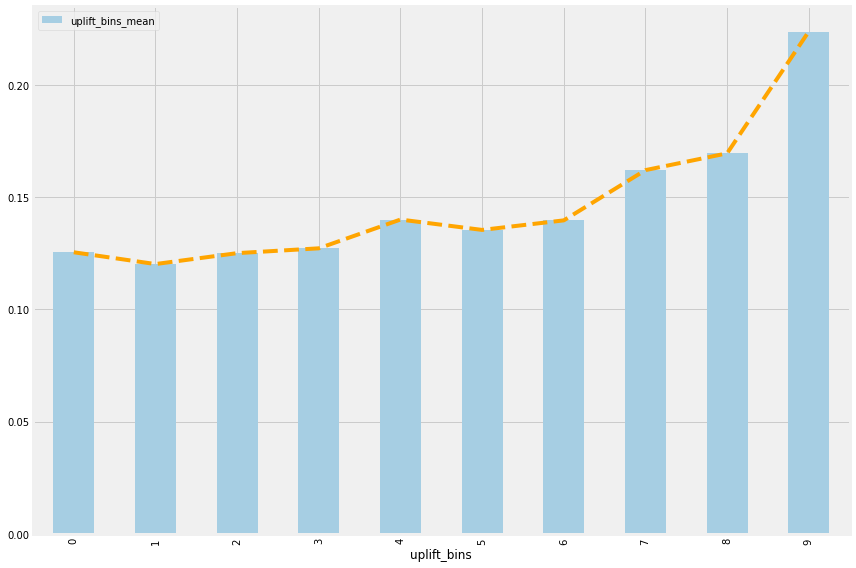

In [379]:
uplift_sm_test = pd.Series(data=uplift_sm, index=treat_test.index, name='uplift')  # uplift prediction for test
X_test_lift = pd.concat([y_test, uplift_sm_test], axis=1).sort_values(by='uplift', ascending=False)  # sort test

uplift_sm_test_cut = pd.qcut(X_test_lift.uplift, q=10, labels=False)  # cut with 10 bins
uplift_sm_test_cut = pd.Series(data=uplift_sm_test_cut, index=uplift_sm_test_cut.index, name='uplift_bins')

conversion_df = pd.DataFrame(data=pd.concat([X_test_lift, uplift_sm_test_cut], axis=1), ).drop('uplift', axis=1)

conversion_df['uplift_bins_mean'] = conversion_df.groupby('uplift_bins')['target'].transform('mean')
dep_conv = conversion_df[['uplift_bins', 'uplift_bins_mean']].groupby('uplift_bins').min()
dep_conv.plot(kind='bar', figsize=(12,8))
plt.plot(dep_conv, c='orange', ls='--')
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()

In [380]:
conversion_df[['uplift_bins', 'uplift_bins_mean']].groupby('uplift_bins').min()

uplift_bins_mean
uplift_bins                  
0                    0.125455
1                    0.120207
2                    0.125065
3                    0.127216
4                    0.140031
5                    0.135417
6                    0.139668
7                    0.162049
8                    0.169527
9                    0.223787

In [381]:
uplift_by_percentile(y_test, uplift_sm,  treat_test, 
                     strategy='by_group', 
                     total=True, std=True, bins=10)

n_treatment  n_control  response_rate_treatment  \
percentile                                                    
0-10               1281        640                 0.246682   
10-20              1281        640                 0.183450   
20-30              1281        639                 0.183450   
30-40              1281        639                 0.158470   
40-50              1281        639                 0.160812   
50-60              1281        639                 0.160031   
60-70              1281        639                 0.129586   
70-80              1281        639                 0.139735   
80-90              1280        639                 0.149219   
90-100             1280        639                 0.139844   
total             12808       6392                 0.165131   

            response_rate_control    uplift  std_treatment  std_control  \
percentile                                                                
0-10                     0.176563  0.070120       0.012044     0.015072   
10-20                    0.140625  0.042825       0.010814     0.013741   
20-30                    0.117371  0.066080       0.010814     0.012733   
30-40                    0.104851  0.053619       0.010203     0.012119   
40-50                    0.086072  0.074740       0.010264     0.011095   
50-60                    0.101721  0.058310       0.010244     0.011958   
60-70                    0.117371  0.012215       0.009384     0.012733   
70-80                    0.098592  0.041143       0.009687     0.011793   
80-90                    0.062598  0.086621       0.009959     0.009583   
90-100                   0.095462  0.044382       0.009694     0.011625   
total                    0.110138  0.054993       0.103106     0.122452   

            std_uplift  
percentile              
0-10          0.019293  
10-20         0.017486  
20-30         0.016705  
30-40         0.015843  
40-50         0.015115  
50-60         0.015746  
60-70         0.015817  
70-80         0.015262  
80-90         0.013821  
90-100        0.015136  
total         0.160223

array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0550'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

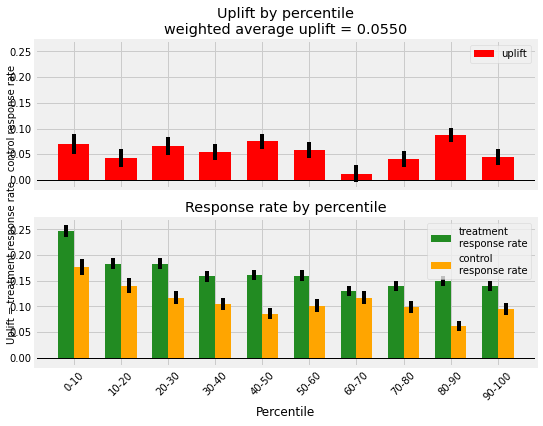

In [382]:
plot_uplift_by_percentile(y_test, uplift_sm, treat_test, strategy='by_group', kind='bar')